In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import itertools

In [2]:
def denoise_image(image, filters):
    '''
    filters=[
        {name:filter1
            n_iter:...,
            params:{
                ...
            }
        },
        {name:filter2
            n_iter:...,
            params:{
                ...
            }
        },
        ...
    ]
    '''
    # print(f"Denoise filters = {filters}")
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, filter['ksize'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(
                        image, d=filter['d'], sigmaColor=filter['sigmaColor'], sigmaSpace=filter['sigmaSpace'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                # case 'non_local_means':
                #     '''
                #     {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                #     '''
                #     image = cv2.fastNlMeansDenoisingColored(
                #         image, **filter['params'])

                # case 'canny':
                #     '''
                #     {'threshold1':5,"threshold2":21}
                #     '''
                #     image = cv2.Canny(image, **filter['params'])

                # case "adaptive":
                #     channel1 = image[:, :, 0]
                #     channel2 = image[:, :, 1]
                #     channel3 = image[:, :, 2]
                #     image[:, :, 0] = adaptive_approach(channel1)
                #     image[:, :, 1] = adaptive_approach(channel2)
                #     image[:, :, 2] = adaptive_approach(channel3)

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

In [3]:
''' 
USA SOLO I FILTRI NELLA LISTA E ITERA SOLO SU ORDINE E NUMERO DI ITERAZIONI + ALTRI PARAMETRI
'''
from itertools import product
from skimage.metrics import structural_similarity as ssim

def rmse(img1, img2):
    rmse_score = np.sqrt(np.mean((img1 - img2) ** 2))
    return rmse_score

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_score = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_score

def cross_correlation(img1, img2):
    img1_norm = (img1 - np.mean(img1)) / np.std(img1)
    img2_norm = (img2 - np.mean(img2)) / np.std(img2)
    corr_coeff = np.mean(img1_norm * img2_norm)
    return corr_coeff

def mae(img1, img2):
    abs_diff = np.abs(img1 - img2)
    mae_score = np.mean(abs_diff)
    return mae_score

def generate_order_permutations(dict_list):
    order_permutations = []
    dict_count = len(dict_list)
    
    # Generate all permutations of the indices of the dictionaries
    for permutation in itertools.permutations(range(dict_count)):
        permuted_list = [dict_list[i] for i in permutation]
        order_permutations.append(permuted_list)
    
    return order_permutations

def calculate_total_iterations(permutazioni):
    total_iterations = 0
    for permutation in permutazioni:
        for filt in permutation:
            #n_iter = len(filt['n_iter'])
            param_combinations_count = len(list(ParameterGrid(filt)))
            total_iterations += param_combinations_count
            # print(f"In permutazione {filt}: {n_iter * param_combinations_count}")
    return total_iterations*len(permutazioni)


def find_best_params(noisy_image_path:str, 
                     denoised_image_path:str, 
                     filters:list
                     ) :
    # Leggo le immagini 

    input_image = cv2.imread(noisy_image_path,cv2.IMREAD_GRAYSCALE)
    input_image_denoised = cv2.imread(denoised_image_path,cv2.IMREAD_GRAYSCALE)  
    
    # Per ogni possibile permutazione dei filtri richiesti
    permutazioni = generate_order_permutations(filters)
    
    # Calcola il numero totale di iterazioni
    total_iterations = calculate_total_iterations(permutazioni)

    # Prova tutte le possibili combinazioni di parametri
    best_score = float('-inf')
    best_params = None
    # with tqdm(total=total_iterations, desc="Testing Combinations") as pbar:
    for param_grids in permutazioni:
        combinations = {f"{i}":[*ParameterGrid(param_grids[i])] for i in range(len(param_grids))}
        
        # Ottieni le liste di elementi per ogni chiave e crea una lista di tuple di elementi
        lists_of_elements = [combinations[key] for key in combinations]            
        combinations_list = [*product(*lists_of_elements)]

        # Stampa le combinazioni
        for combo in combinations_list:
            filtered_image = denoise_image(input_image, list(combo))
        
            # Calcola una qualche metrica di qualità dell'immagine filtrata, ad esempio l'errore quadratico medio
            """
            SCEGLI QUALE SCORE USARE
            """
            
            
            sift = cv2.xfeatures2d.SIFT_create()
            kp_query = sift.detect(input_image_denoised)
            kp_train = sift.detect(filtered_image)
            kp_query, des_query = sift.compute(input_image_denoised, kp_query)
            kp_train, des_train = sift.compute(filtered_image, kp_train)
            
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
            search_params = dict(checks = 150)
            flann = cv2.FlannBasedMatcher(index_params, search_params)
            matches = flann.knnMatch(des_query,des_train,k=2)
            
            good = []
            for m, n in matches:
                if m.distance < 0.8*n.distance:
                    good.append(m)
            score = len(good)
            # score = np.mean((input_image_denoised - filtered_image) ** 2)
            # score = np.linalg.norm((input_image_denoised - filtered_image))
            #score= ssim(input_image_denoised, filtered_image,data_range=filtered_image.max()-filtered_image.min())
            # score = psnr(input_image_denoised, filtered_image)
            # score = cross_correlation(input_image_denoised, filtered_image)
            # score = mae(input_image_denoised, filtered_image)
            # score = rmse(input_image_denoised, filtered_image)
            
            
            # Aggiorna i parametri se otteniamo una migliore qualità dell'immagine filtrata
            if score > best_score:
                best_score = score
                best_params = list(combo)
                print(score,combo)
                # Aggiorna la barra di avanzamento
                # pbar.update(1)
                src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
                # Using RANSAC to estimate a robust homography.
                # It returns the homography M and a mask for the discarded points
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Mask of discarded point used in visualization
                matchesMask = mask.ravel().tolist()    
                draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None, # not draw keypoints only matching lines
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2) # not draw keypoints only lines
                img3 = cv2.drawMatches(input_image_denoised,kp_query,filtered_image,kp_train,good,None,**draw_params)
                plt.imshow(img3, 'gray')
                plt.show()
    print("Migliori parametri:", best_params)

    # Applica il bilateral filtering con i migliori parametri
    filtered_image = denoise_image(input_image, best_params)

    # Visualizza l'immagine filtrata
    plt.figure(figsize=(20,20))
    plt.subplot(131); plt.imshow(input_image[:,:,::-1]); plt.title("Input Image")
    plt.subplot(132); plt.imshow(input_image_denoised[:,:,::-1]); plt.title("Perfectly-denoised Image")
    plt.subplot(133); plt.imshow(filtered_image[:,:,::-1]); plt.title("Filtered Image")
    plt.show()

    # Visualizza errore
    plt.figure(figsize=(10,10))
    plt.imshow(abs(input_image[:,:,::-1]-filtered_image[:,:,::-1])); plt.title("Filtering error")
    
    return best_params

243 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 10, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 0, 'name': 'median'}, {'ksize': 3, 'n_iter': 0, 'name': 'median'})


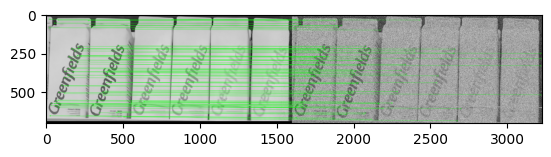

249 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 10, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 0, 'name': 'median'}, {'ksize': 3, 'n_iter': 1, 'name': 'median'})


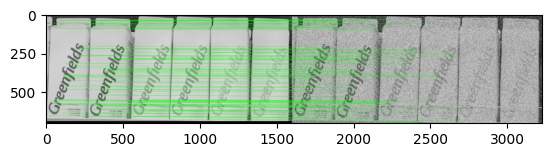

251 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 10, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 1, 'name': 'median'}, {'ksize': 5, 'n_iter': 0, 'name': 'median'})


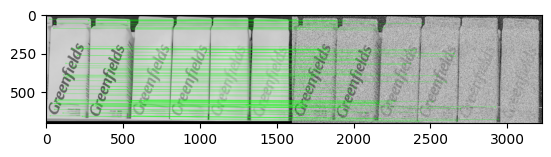

259 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 10, 'sigmaSpace': 10}, {'ksize': 5, 'n_iter': 1, 'name': 'median'}, {'ksize': 3, 'n_iter': 2, 'name': 'median'})


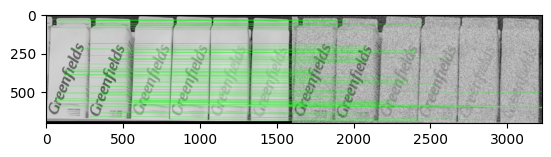

260 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 10, 'sigmaSpace': 40}, {'ksize': 5, 'n_iter': 1, 'name': 'median'}, {'ksize': 3, 'n_iter': 2, 'name': 'median'})


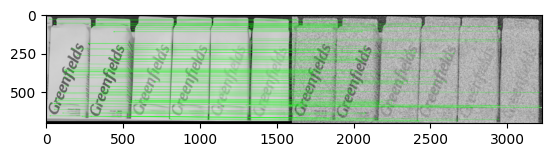

262 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 10, 'sigmaSpace': 100}, {'ksize': 3, 'n_iter': 1, 'name': 'median'}, {'ksize': 7, 'n_iter': 0, 'name': 'median'})


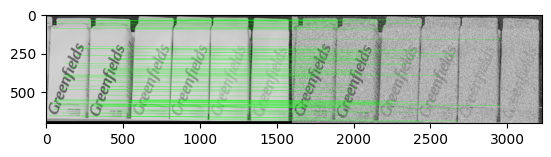

266 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 40, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 0, 'name': 'median'}, {'ksize': 5, 'n_iter': 1, 'name': 'median'})


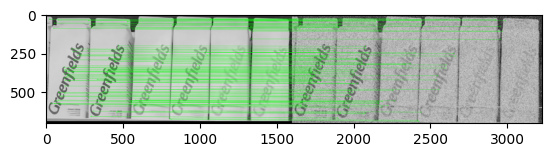

272 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 40, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 1, 'name': 'median'}, {'ksize': 7, 'n_iter': 2, 'name': 'median'})


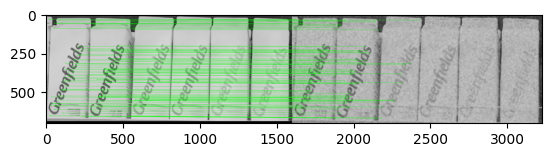

277 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 40, 'sigmaSpace': 10}, {'ksize': 5, 'n_iter': 2, 'name': 'median'}, {'ksize': 3, 'n_iter': 2, 'name': 'median'})


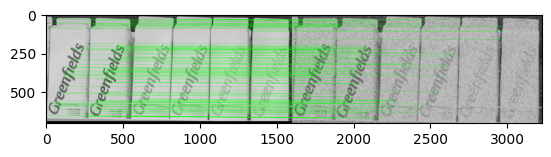

278 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 40, 'sigmaSpace': 100}, {'ksize': 5, 'n_iter': 2, 'name': 'median'}, {'ksize': 3, 'n_iter': 2, 'name': 'median'})


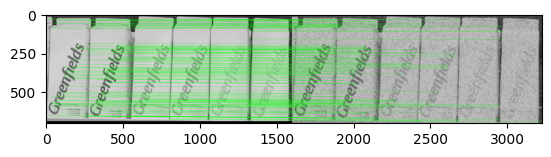

282 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 40, 'sigmaSpace': 130}, {'ksize': 5, 'n_iter': 2, 'name': 'median'}, {'ksize': 3, 'n_iter': 1, 'name': 'median'})


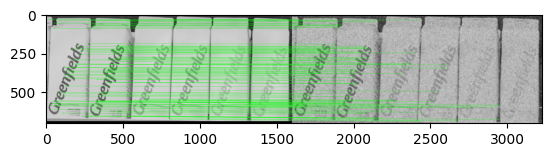

290 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 70, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 0, 'name': 'median'}, {'ksize': 5, 'n_iter': 1, 'name': 'median'})


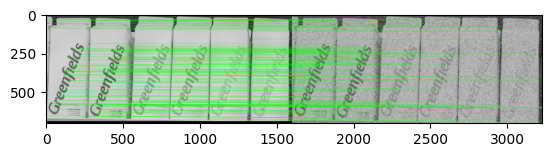

296 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 70, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 1, 'name': 'median'}, {'ksize': 7, 'n_iter': 2, 'name': 'median'})


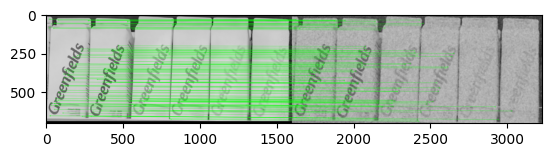

299 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 70, 'sigmaSpace': 100}, {'ksize': 7, 'n_iter': 1, 'name': 'median'}, {'ksize': 3, 'n_iter': 2, 'name': 'median'})


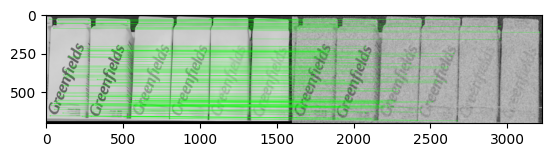

302 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 100, 'sigmaSpace': 10}, {'ksize': 5, 'n_iter': 1, 'name': 'median'}, {'ksize': 5, 'n_iter': 2, 'name': 'median'})


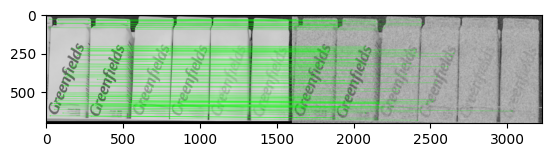

303 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 100, 'sigmaSpace': 100}, {'ksize': 5, 'n_iter': 1, 'name': 'median'}, {'ksize': 5, 'n_iter': 2, 'name': 'median'})


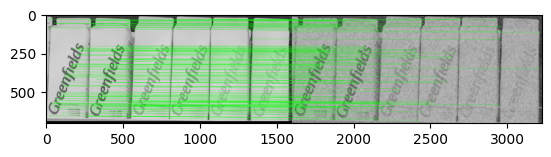

309 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 130, 'sigmaSpace': 10}, {'ksize': 3, 'n_iter': 2, 'name': 'median'}, {'ksize': 5, 'n_iter': 2, 'name': 'median'})


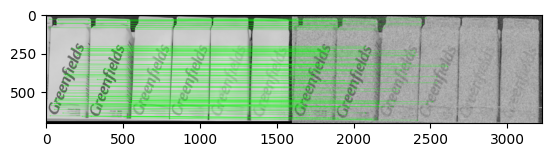

315 ({'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 130, 'sigmaSpace': 40}, {'ksize': 3, 'n_iter': 2, 'name': 'median'}, {'ksize': 5, 'n_iter': 2, 'name': 'median'})


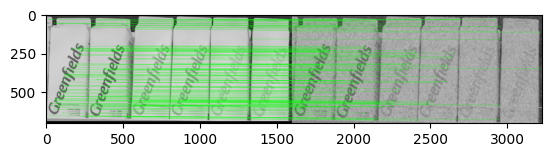

Migliori parametri: [{'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 130, 'sigmaSpace': 40}, {'ksize': 3, 'n_iter': 2, 'name': 'median'}, {'ksize': 5, 'n_iter': 2, 'name': 'median'}]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

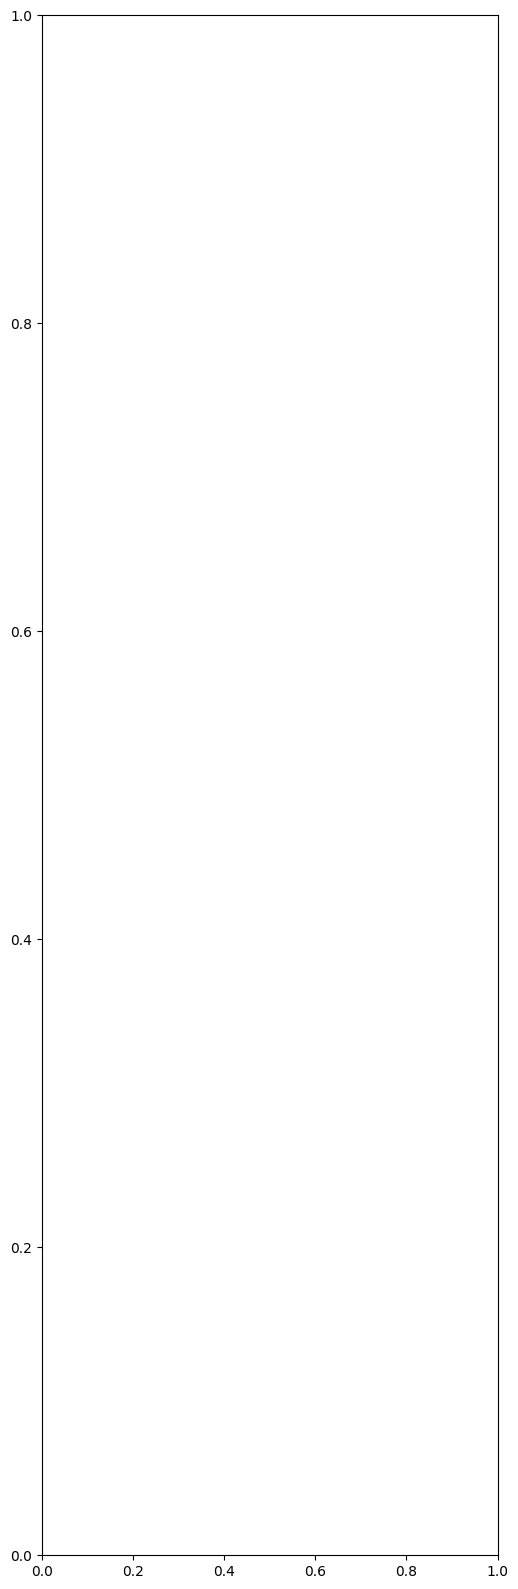

In [4]:
path_noised = "scene12.png"
path_DEnoised = "scene12_ai.jpeg"

best_params = find_best_params(
    noisy_image_path=path_noised,
    denoised_image_path=path_DEnoised,
    filters=[
        {   
           "name": ["bilateral"],
           "n_iter": [*range(1,2)],  # Modifica qui, avvolgi il valore in una lista
           "d": [*range(5, 9, 2)],
           'sigmaColor':[*range(10,150,30)],
           'sigmaSpace':[*range(10,150,30)]
        },
        {   
           "name": ["median"],
           "n_iter": [*range(0,3)],  # Modifica qui, avvolgi il valore in una lista
           "ksize": [*range(3, 9, 2)]
        },
        {   
           "name": ["median"],
           "n_iter": [*range(0,3)],  # Modifica qui, avvolgi il valore in una lista
           "ksize": [*range(3, 9, 2)]
        },
    ]
)